In [1]:
import numpy as np
import seaborn as sn
from imblearn.over_sampling import SMOTE 
import keras
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from pandas import DataFrame
import xlsxwriter
import time


#Extra features that are available: Sex, Gestational Age 

#22 1s Atypicals defined as having an attention problem t-score >= 65 in BASC2 6year
#115 0s

Using TensorFlow backend.


In [2]:
Training_Data = pd.ExcelFile("Scaled_Gilmore_Data_CT_SA_1_2.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Middle', 'ATP Label'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','ATP Middle', 'HYP Middle', 'ATP Label'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

seed = 7 #Set to the same seed as my gridSearchCV until I can run more gridSearchCVs with random seeds and average them. This is after I try the different class weight gridSearches.
print("SEED:",seed)

(137, 298)
(137, 1)
SEED: 7


In [3]:
data_features = data_features.to_numpy()
labels = labels.to_numpy()

skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_folds_X = []
testing_folds_X = []
training_folds_Y = []
testing_folds_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features[train_index], data_features[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed, k_neighbors=2) 
    X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    
    training_folds_X.append(X_train_smoted)
    testing_folds_X.append(X_test)
    training_folds_Y.append(Y_train_smoted)
    testing_folds_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)


In [4]:
def create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7):
    predictions = []
    true = []
    
    for i in range(0,p0.size):
        if p0[i] == 0:
            predictions.append(0)
        if p0[i] == 1:
            predictions.append(1)
        if t0[i] == 0:
            true.append(0)
        if t0[i] == 1:
            true.append(1)
    for i in range(0,p1.size):
        if p1[i] == 0:
            predictions.append(0)
        if p1[i] == 1:
            predictions.append(1)
        if t1[i] == 0:
            true.append(0)
        if t1[i] == 1:
            true.append(1)
    for i in range(0,p2.size):
        if p2[i] == 0:
            predictions.append(0)
        if p2[i] == 1:
            predictions.append(1)
        if t2[i] == 0:
            true.append(0)
        if t2[i] == 1:
            true.append(1)
    for i in range(0,p3.size):
        if p3[i] == 0:
            predictions.append(0)
        if p3[i] == 1:
            predictions.append(1)
        if t3[i] == 0:
            true.append(0)
        if t3[i] == 1:
            true.append(1)
    for i in range(0,p4.size):
        if p4[i] == 0:
            predictions.append(0)
        if p4[i] == 1:
            predictions.append(1)
        if t4[i] == 0:
            true.append(0)
        if t4[i] == 1:
            true.append(1)
    for i in range(0,p5.size):
        if p5[i] == 0:
            predictions.append(0)
        if p5[i] == 1:
            predictions.append(1)
        if t5[i] == 0:
            true.append(0)
        if t5[i] == 1:
            true.append(1)
    for i in range(0,p6.size):
        if p6[i] == 0:
            predictions.append(0)
        if p6[i] == 1:
            predictions.append(1)
        if t6[i] == 0:
            true.append(0)
        if t6[i] == 1:
            true.append(1)
    for i in range(0,p7.size):
        if p7[i] == 0:
            predictions.append(0)
        if p7[i] == 1:
            predictions.append(1)
        if t7[i] == 0:
            true.append(0)
        if t7[i] == 1:
            true.append(1)
    
    
    prec_score = precision_score(true, predictions, average=None)
    print('Positive Predictive Value tp/(tp+fp): ',prec_score[1])
    
    rec_score = recall_score(true, predictions, average=None)
    print('Recall Value tp/(tp+fn): ',rec_score[1])
    
    cf_matrix = confusion_matrix(true, predictions)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    

In [5]:
#Best: 0.508814 using {'batch_size': 35, 'dropout': 0.15, 'epochs': 35, 'layer1_size': 100, 'layer2_size': 15}
def run_model(n):
    input_size = 298
    hidden_size1 = 100
    hidden_size2 = 15
    output_size = 1
    
    input_data = Input(shape=(input_size,))
    hidden_d_1 = Dense(hidden_size1, activation='relu')(input_data)
    hidden_d_1_d = Dropout(0.15,  noise_shape=None, seed=None)(hidden_d_1)
    hidden_d_2 = Dense(hidden_size2, activation='relu')(hidden_d_1_d)
    predicted = Dense(output_size, activation='sigmoid')(hidden_d_2)

    predictor = Model(input_data, predicted)
    predictor.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'] )

    class_weights={0:1, 1:5} 
    
    p = predictor.fit(training_folds_X[n], training_folds_Y[n],
    epochs=100,
    batch_size=35,
    shuffle=True,
    validation_data=(testing_folds_X[n], testing_folds_Y[n]), class_weight=class_weights)

    #Plotting loss
    plt.plot(p.history['loss'])
    plt.plot(p.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.axis([0, 30, 0.0, 1.10])
    plt.show()

    #Plotting Accuracy
    plt.plot(p.history['acc'])
    plt.plot(p.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.axis([0, 30, 0.0, 1.05])
    plt.show()
    
    
    predictions = predictor.predict(testing_folds_X[n])
    predicted_classes = (predictions > 0.5).astype(int)

    #Heatmap for the confusion matrix
    cf_matrix = confusion_matrix(testing_folds_Y[n], predicted_classes)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    average_precision = average_precision_score(predicted_classes, testing_folds_Y[n])

    
    prec_score = precision_score(testing_folds_Y[n], predicted_classes, average=None)
    print('PPV: ',prec_score[1])
    
    rec_score = recall_score(testing_folds_Y[n], predicted_classes, average=None)
    print('Recall: ',rec_score[1])

    
    return predicted_classes, testing_folds_Y[n]
    


Train on 214 samples, validate on 18 samples
Epoch 1/100
214/214 [==============================] - 3s 14ms/step - loss: 1.7440 - acc: 0.4813 - val_loss: 1.5935 - val_acc: 0.1111
Epoch 2/100
214/214 [==============================] - 0s 224us/step - loss: 1.3966 - acc: 0.5000 - val_loss: 1.7822 - val_acc: 0.1111
Epoch 3/100
214/214 [==============================] - 0s 294us/step - loss: 1.3245 - acc: 0.5000 - val_loss: 1.3516 - val_acc: 0.1111
Epoch 4/100
214/214 [==============================] - 0s 289us/step - loss: 1.3175 - acc: 0.5000 - val_loss: 1.2621 - val_acc: 0.1111
Epoch 5/100
214/214 [==============================] - 0s 308us/step - loss: 1.2546 - acc: 0.5000 - val_loss: 1.5487 - val_acc: 0.1111
Epoch 6/100
214/214 [==============================] - 0s 224us/step - loss: 1.2043 - acc: 0.5000 - val_loss: 1.5574 - val_acc: 0.1111
Epoch 7/100
214/214 [==============================] - 0s 396us/step - loss: 1.1929 - acc: 0.5000 - val_loss: 1.4492 - val_acc: 0.1111
Epoch 8/100

Epoch 61/100
214/214 [==============================] - 0s 242us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.5216 - val_acc: 0.7778
Epoch 62/100
214/214 [==============================] - 0s 326us/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.5272 - val_acc: 0.7778
Epoch 63/100
214/214 [==============================] - 0s 261us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.5318 - val_acc: 0.7778
Epoch 64/100
214/214 [==============================] - 0s 275us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.5352 - val_acc: 0.7778
Epoch 65/100
214/214 [==============================] - 0s 350us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.5484 - val_acc: 0.7778
Epoch 66/100
214/214 [==============================] - 0s 266us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.5530 - val_acc: 0.7778
Epoch 67/100
214/214 [==============================] - 0s 364us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.5583 - val_acc: 0.7778
Epoch 68/100
214/214 [==========================

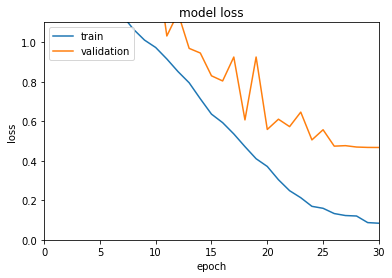

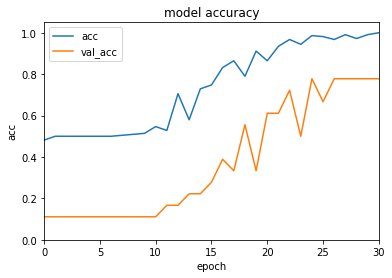

[[13  3]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


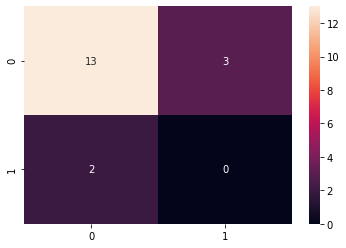

In [6]:
p0, t0 = run_model(0)

Train on 214 samples, validate on 17 samples
Epoch 1/100
214/214 [==============================] - 3s 15ms/step - loss: 1.6566 - acc: 0.5047 - val_loss: 1.5158 - val_acc: 0.0588
Epoch 2/100
214/214 [==============================] - 0s 405us/step - loss: 1.3307 - acc: 0.5000 - val_loss: 1.8921 - val_acc: 0.0588
Epoch 3/100
214/214 [==============================] - 0s 345us/step - loss: 1.3203 - acc: 0.5000 - val_loss: 1.7116 - val_acc: 0.0588
Epoch 4/100
214/214 [==============================] - 0s 266us/step - loss: 1.2677 - acc: 0.5000 - val_loss: 1.5993 - val_acc: 0.0588
Epoch 5/100
214/214 [==============================] - 0s 275us/step - loss: 1.2318 - acc: 0.5000 - val_loss: 1.6337 - val_acc: 0.0588
Epoch 6/100
214/214 [==============================] - 0s 261us/step - loss: 1.1875 - acc: 0.5000 - val_loss: 1.5647 - val_acc: 0.0588
Epoch 7/100
214/214 [==============================] - 0s 284us/step - loss: 1.1185 - acc: 0.5000 - val_loss: 1.3462 - val_acc: 0.0588
Epoch 8/100

Epoch 61/100
214/214 [==============================] - 0s 247us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.1531 - val_acc: 0.9412
Epoch 62/100
214/214 [==============================] - 0s 275us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 0.9412
Epoch 63/100
214/214 [==============================] - 0s 275us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.1517 - val_acc: 0.9412
Epoch 64/100
214/214 [==============================] - 0s 364us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.1575 - val_acc: 0.9412
Epoch 65/100
214/214 [==============================] - 0s 331us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.1424 - val_acc: 0.9412
Epoch 66/100
214/214 [==============================] - 0s 154us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.1444 - val_acc: 0.9412
Epoch 67/100
214/214 [==============================] - 0s 135us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.1671 - val_acc: 0.9412
Epoch 68/100
214/214 [==========================

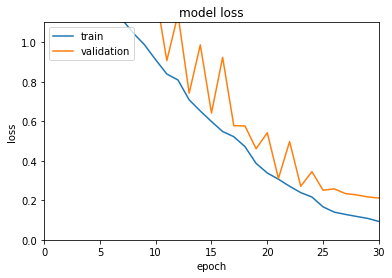

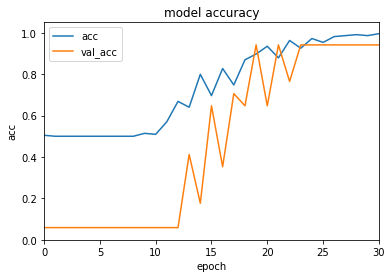

[[16  0]
 [ 1  0]]
PPV:  0.0
Recall:  0.0


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


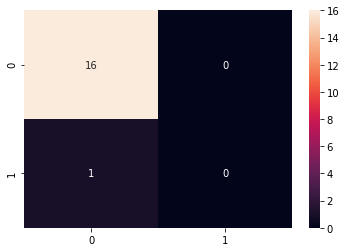

In [7]:
p1, t1 = run_model(1)

Train on 214 samples, validate on 17 samples
Epoch 1/100
214/214 [==============================] - 3s 15ms/step - loss: 1.5974 - acc: 0.5374 - val_loss: 1.8666 - val_acc: 0.0588
Epoch 2/100
214/214 [==============================] - 0s 377us/step - loss: 1.3295 - acc: 0.5000 - val_loss: 1.6911 - val_acc: 0.0588
Epoch 3/100
214/214 [==============================] - 0s 443us/step - loss: 1.3068 - acc: 0.5000 - val_loss: 1.5278 - val_acc: 0.0588
Epoch 4/100
214/214 [==============================] - 0s 354us/step - loss: 1.2726 - acc: 0.5000 - val_loss: 1.7947 - val_acc: 0.0588
Epoch 5/100
214/214 [==============================] - 0s 583us/step - loss: 1.2346 - acc: 0.5000 - val_loss: 1.4878 - val_acc: 0.0588
Epoch 6/100
214/214 [==============================] - 0s 419us/step - loss: 1.1863 - acc: 0.5000 - val_loss: 1.3874 - val_acc: 0.0588
Epoch 7/100
214/214 [==============================] - 0s 433us/step - loss: 1.1642 - acc: 0.5000 - val_loss: 1.4112 - val_acc: 0.0588
Epoch 8/100

Epoch 61/100
214/214 [==============================] - 0s 261us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.3610 - val_acc: 0.9412
Epoch 62/100
214/214 [==============================] - 0s 294us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.3769 - val_acc: 0.9412
Epoch 63/100
214/214 [==============================] - 0s 284us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.3726 - val_acc: 0.9412
Epoch 64/100
214/214 [==============================] - 0s 317us/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.3818 - val_acc: 0.9412
Epoch 65/100
214/214 [==============================] - 0s 275us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.3790 - val_acc: 0.9412
Epoch 66/100
214/214 [==============================] - 0s 303us/step - loss: 0.0087 - acc: 1.0000 - val_loss: 0.3899 - val_acc: 0.9412
Epoch 67/100
214/214 [==============================] - 0s 289us/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.3847 - val_acc: 0.9412
Epoch 68/100
214/214 [==========================

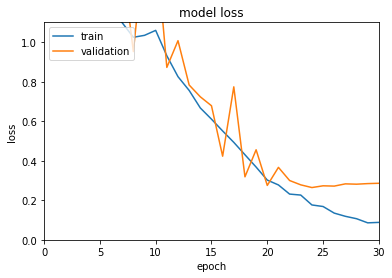

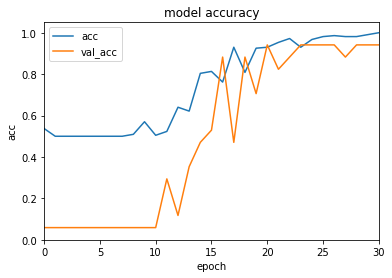

[[16  0]
 [ 1  0]]
PPV:  0.0
Recall:  0.0


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


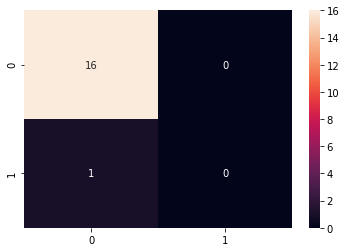

In [8]:
p2, t2 = run_model(2)

Train on 216 samples, validate on 17 samples
Epoch 1/100
216/216 [==============================] - 3s 13ms/step - loss: 1.6984 - acc: 0.5185 - val_loss: 1.4575 - val_acc: 0.1176
Epoch 2/100
216/216 [==============================] - 0s 254us/step - loss: 1.3946 - acc: 0.5000 - val_loss: 1.9993 - val_acc: 0.1176
Epoch 3/100
216/216 [==============================] - 0s 314us/step - loss: 1.4113 - acc: 0.5000 - val_loss: 1.8607 - val_acc: 0.1176
Epoch 4/100
216/216 [==============================] - 0s 235us/step - loss: 1.3297 - acc: 0.5000 - val_loss: 1.4301 - val_acc: 0.1176
Epoch 5/100
216/216 [==============================] - 0s 296us/step - loss: 1.3356 - acc: 0.5000 - val_loss: 1.3791 - val_acc: 0.1176
Epoch 6/100
216/216 [==============================] - 0s 282us/step - loss: 1.2836 - acc: 0.5000 - val_loss: 1.5437 - val_acc: 0.1176
Epoch 7/100
216/216 [==============================] - 0s 259us/step - loss: 1.2347 - acc: 0.5000 - val_loss: 1.4581 - val_acc: 0.1176
Epoch 8/100

Epoch 61/100
216/216 [==============================] - 0s 540us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.5308 - val_acc: 0.8824
Epoch 62/100
216/216 [==============================] - 0s 342us/step - loss: 0.0088 - acc: 1.0000 - val_loss: 0.5353 - val_acc: 0.9412
Epoch 63/100
216/216 [==============================] - 0s 383us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.5389 - val_acc: 0.8824
Epoch 64/100
216/216 [==============================] - 0s 342us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.5415 - val_acc: 0.9412
Epoch 65/100
216/216 [==============================] - 0s 406us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.5462 - val_acc: 0.8824
Epoch 66/100
216/216 [==============================] - 0s 365us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.5515 - val_acc: 0.8824
Epoch 67/100
216/216 [==============================] - ETA: 0s - loss: 0.0066 - acc: 1.000 - 0s 332us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.5547 - val_acc: 0.8824
Epoch 68/1

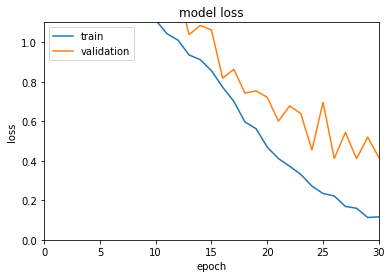

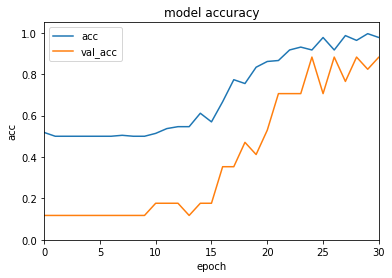

[[15  0]
 [ 1  1]]
PPV:  1.0
Recall:  0.5


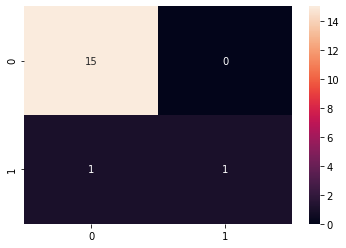

In [9]:
p3, t3 = run_model(3)

Train on 216 samples, validate on 17 samples
Epoch 1/100
216/216 [==============================] - 3s 15ms/step - loss: 1.5945 - acc: 0.5093 - val_loss: 1.3790 - val_acc: 0.1176
Epoch 2/100
216/216 [==============================] - 0s 286us/step - loss: 1.3670 - acc: 0.5000 - val_loss: 1.8544 - val_acc: 0.1176
Epoch 3/100
216/216 [==============================] - 0s 268us/step - loss: 1.3571 - acc: 0.5000 - val_loss: 1.5595 - val_acc: 0.1176
Epoch 4/100
216/216 [==============================] - 0s 374us/step - loss: 1.2953 - acc: 0.5000 - val_loss: 1.3518 - val_acc: 0.1176
Epoch 5/100
216/216 [==============================] - 0s 332us/step - loss: 1.2499 - acc: 0.5000 - val_loss: 1.3096 - val_acc: 0.1176
Epoch 6/100
216/216 [==============================] - 0s 351us/step - loss: 1.2040 - acc: 0.5000 - val_loss: 1.2741 - val_acc: 0.1176
Epoch 7/100
216/216 [==============================] - 0s 226us/step - loss: 1.1665 - acc: 0.5000 - val_loss: 1.4658 - val_acc: 0.1176
Epoch 8/100

Epoch 61/100
216/216 [==============================] - 0s 328us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.7107 - val_acc: 0.8824
Epoch 62/100
216/216 [==============================] - 0s 305us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.7201 - val_acc: 0.8824
Epoch 63/100
216/216 [==============================] - 0s 277us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.7498 - val_acc: 0.8824
Epoch 64/100
216/216 [==============================] - 0s 272us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 0.7428 - val_acc: 0.8824
Epoch 65/100
216/216 [==============================] - 0s 305us/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.7321 - val_acc: 0.8824
Epoch 66/100
216/216 [==============================] - 0s 332us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.7783 - val_acc: 0.8824
Epoch 67/100
216/216 [==============================] - 0s 282us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.7714 - val_acc: 0.8824
Epoch 68/100
216/216 [==========================

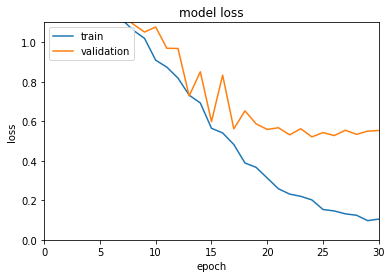

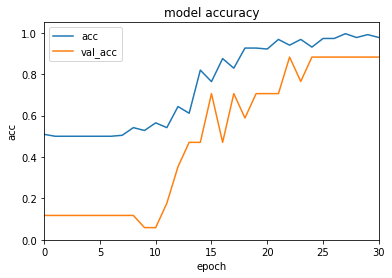

[[15  0]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


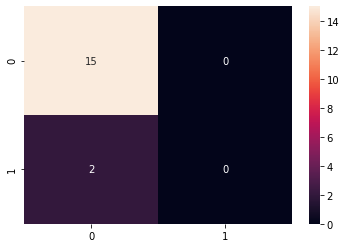

In [10]:
p4, t4 = run_model(4)

Train on 216 samples, validate on 17 samples
Epoch 1/100
216/216 [==============================] - 3s 14ms/step - loss: 1.5953 - acc: 0.5046 - val_loss: 2.0939 - val_acc: 0.1176
Epoch 2/100
216/216 [==============================] - 0s 272us/step - loss: 1.3752 - acc: 0.5000 - val_loss: 1.4956 - val_acc: 0.1176
Epoch 3/100
216/216 [==============================] - 0s 337us/step - loss: 1.3097 - acc: 0.5000 - val_loss: 1.3587 - val_acc: 0.1176
Epoch 4/100
216/216 [==============================] - 0s 286us/step - loss: 1.2482 - acc: 0.5000 - val_loss: 1.5338 - val_acc: 0.1176
Epoch 5/100
216/216 [==============================] - 0s 369us/step - loss: 1.1685 - acc: 0.5093 - val_loss: 1.3552 - val_acc: 0.1176
Epoch 6/100
216/216 [==============================] - 0s 291us/step - loss: 1.1231 - acc: 0.5093 - val_loss: 1.4304 - val_acc: 0.1176
Epoch 7/100
216/216 [==============================] - 0s 305us/step - loss: 1.0673 - acc: 0.5278 - val_loss: 1.2375 - val_acc: 0.1765
Epoch 8/100

Epoch 61/100
216/216 [==============================] - 0s 300us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.7609 - val_acc: 0.8235
Epoch 62/100
216/216 [==============================] - 0s 235us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.7477 - val_acc: 0.8235
Epoch 63/100
216/216 [==============================] - 0s 309us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.7376 - val_acc: 0.8235
Epoch 64/100
216/216 [==============================] - 0s 217us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.7238 - val_acc: 0.8235
Epoch 65/100
216/216 [==============================] - 0s 305us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.7392 - val_acc: 0.8235
Epoch 66/100
216/216 [==============================] - 0s 332us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.7612 - val_acc: 0.8235
Epoch 67/100
216/216 [==============================] - 0s 263us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.7783 - val_acc: 0.8235
Epoch 68/100
216/216 [==========================

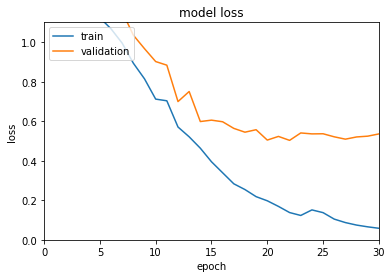

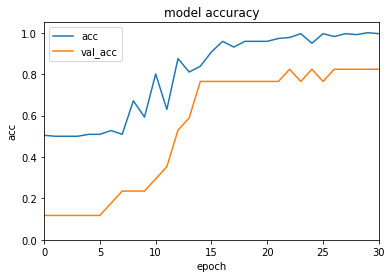

[[15  0]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


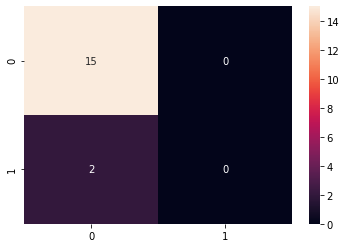

In [11]:
p5, t5 = run_model(5)

Train on 216 samples, validate on 17 samples
Epoch 1/100
216/216 [==============================] - 3s 16ms/step - loss: 1.4374 - acc: 0.5093 - val_loss: 1.9509 - val_acc: 0.1176
Epoch 2/100
216/216 [==============================] - 0s 397us/step - loss: 1.3336 - acc: 0.5000 - val_loss: 1.5567 - val_acc: 0.1176
Epoch 3/100
216/216 [==============================] - 0s 388us/step - loss: 1.2524 - acc: 0.5000 - val_loss: 1.4559 - val_acc: 0.1176
Epoch 4/100
216/216 [==============================] - 0s 531us/step - loss: 1.1975 - acc: 0.5000 - val_loss: 1.4102 - val_acc: 0.1176
Epoch 5/100
216/216 [==============================] - 0s 402us/step - loss: 1.1412 - acc: 0.5000 - val_loss: 1.3519 - val_acc: 0.1176
Epoch 6/100
216/216 [==============================] - 0s 425us/step - loss: 1.0449 - acc: 0.5000 - val_loss: 1.1696 - val_acc: 0.1176
Epoch 7/100
216/216 [==============================] - 0s 231us/step - loss: 0.9966 - acc: 0.5509 - val_loss: 1.1981 - val_acc: 0.1765
Epoch 8/100

Epoch 61/100
216/216 [==============================] - 0s 268us/step - loss: 0.0181 - acc: 1.0000 - val_loss: 0.6864 - val_acc: 0.8824
Epoch 62/100
216/216 [==============================] - 0s 203us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.6493 - val_acc: 0.8824
Epoch 63/100
216/216 [==============================] - 0s 254us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.6675 - val_acc: 0.8824
Epoch 64/100
216/216 [==============================] - 0s 235us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.7115 - val_acc: 0.8824
Epoch 65/100
216/216 [==============================] - 0s 259us/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.7159 - val_acc: 0.8824
Epoch 66/100
216/216 [==============================] - 0s 259us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.7100 - val_acc: 0.8824
Epoch 67/100
216/216 [==============================] - 0s 277us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.7033 - val_acc: 0.8824
Epoch 68/100
216/216 [==========================

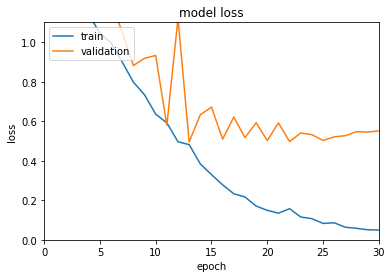

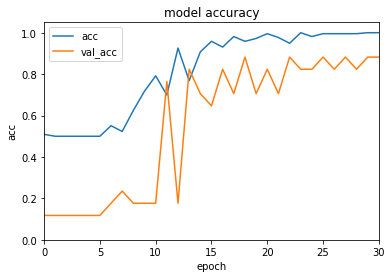

[[15  0]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


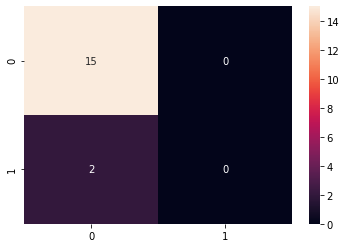

In [12]:
p6, t6 = run_model(6)

Train on 216 samples, validate on 17 samples
Epoch 1/100
216/216 [==============================] - 3s 12ms/step - loss: 2.1237 - acc: 0.4722 - val_loss: 0.8208 - val_acc: 0.1176
Epoch 2/100
216/216 [==============================] - 0s 152us/step - loss: 1.6766 - acc: 0.5046 - val_loss: 1.0881 - val_acc: 0.1176
Epoch 3/100
216/216 [==============================] - 0s 148us/step - loss: 1.4223 - acc: 0.5000 - val_loss: 1.4093 - val_acc: 0.1176
Epoch 4/100
216/216 [==============================] - 0s 139us/step - loss: 1.3653 - acc: 0.5000 - val_loss: 1.6242 - val_acc: 0.1176
Epoch 5/100
216/216 [==============================] - 0s 162us/step - loss: 1.3583 - acc: 0.5000 - val_loss: 1.7218 - val_acc: 0.1176
Epoch 6/100
216/216 [==============================] - 0s 139us/step - loss: 1.3549 - acc: 0.5000 - val_loss: 1.5504 - val_acc: 0.1176
Epoch 7/100
216/216 [==============================] - 0s 166us/step - loss: 1.3108 - acc: 0.5000 - val_loss: 1.4467 - val_acc: 0.1176
Epoch 8/100

Epoch 61/100
216/216 [==============================] - 0s 162us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.5397 - val_acc: 0.9412
Epoch 62/100
216/216 [==============================] - 0s 180us/step - loss: 0.0182 - acc: 0.9954 - val_loss: 0.5411 - val_acc: 0.9412
Epoch 63/100
216/216 [==============================] - 0s 180us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.5477 - val_acc: 0.9412
Epoch 64/100
216/216 [==============================] - 0s 166us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.5630 - val_acc: 0.8824
Epoch 65/100
216/216 [==============================] - 0s 171us/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.5643 - val_acc: 0.8824
Epoch 66/100
216/216 [==============================] - 0s 171us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.5626 - val_acc: 0.9412
Epoch 67/100
216/216 [==============================] - 0s 152us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.5658 - val_acc: 0.9412
Epoch 68/100
216/216 [==========================

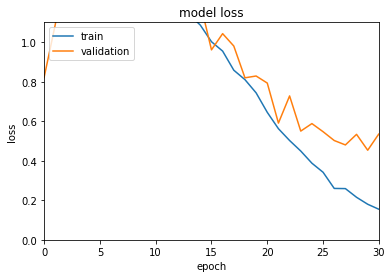

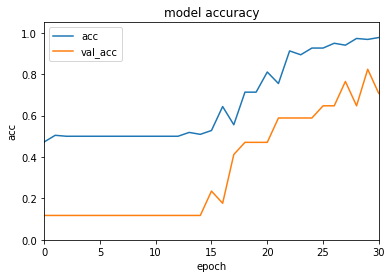

[[15  0]
 [ 1  1]]
PPV:  1.0
Recall:  0.5


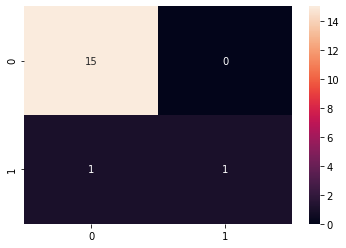

In [13]:
p7, t7 = run_model(7)

Positive Predictive Value tp/(tp+fp):  0.4
Recall Value tp/(tp+fn):  0.14285714285714285
[[120   3]
 [ 12   2]]


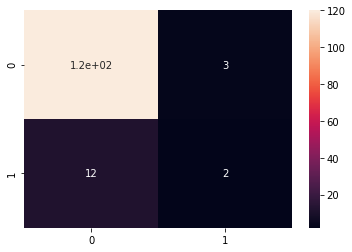

In [14]:
create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7)